# Satellite Images of Water Bodies

1. Dataset<br>
A collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water and black represents something else but water.<br>
Data comes from Kaggle: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

2. Project<br>
The goal of this project was to use a standard U-net implementation for image segmentation, more specifically, to train the network to recognize and locate bodies of water on the image.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [3]:
# Unpack data
!tar xf /content/drive/MyDrive/unet/archive.tar.gz -C /content

In [4]:
image_path = 'Water Bodies Dataset/Images/'
mask_path = 'Water Bodies Dataset/Masks/'
SIZE = 128

In [5]:
# lists of images and masks names
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = np.asarray(Image.open(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = np.asarray(Image.open(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:32<00:00, 86.89it/s] 


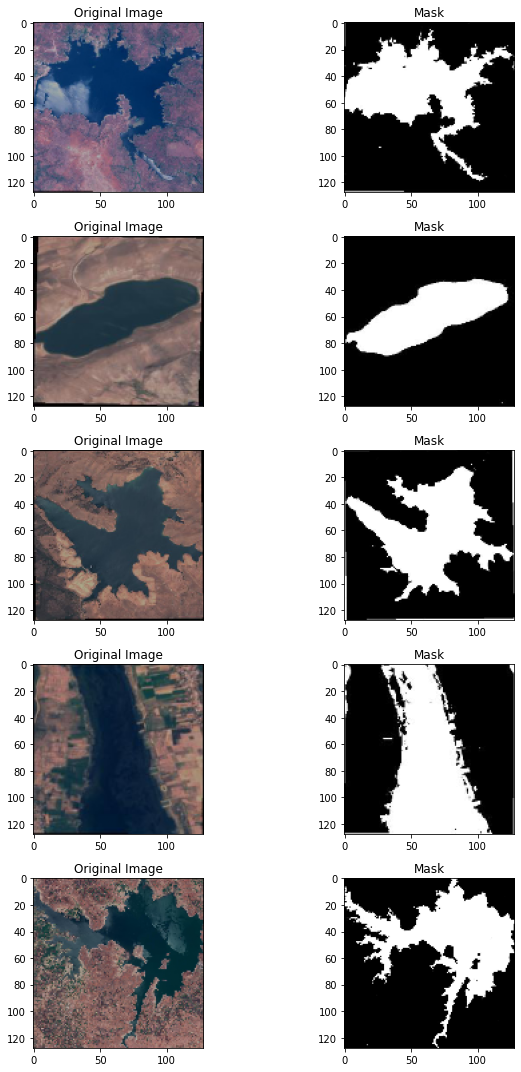

In [6]:
# Plot some images and its masks
plt.figure(figsize=(10,15))
for i in range(1,11):
  plt.subplot(5,2,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id], cmap=None)
    plt.title('Original Image')
  elif i%2==0:
    plt.imshow(masks[id].reshape(128,128), cmap='gray')
    plt.title('Mask')

plt.tight_layout()
plt.show()

In [7]:
# Train test split
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [8]:
# Define U-net architecture
def unet_model(input_layer, start_neurons):
    # Contraction path
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(convm)
    
    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, kernel_size=(3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    
    # Last conv and output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [9]:
# Compile unet model
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer = input_layer, start_neurons = 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [10]:
# Post Process
def mask_threshold(image, threshold=0.25):
  return image>threshold

# Callback to show progress of learning on the images after each epoch
class ShowProgress(Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    k = np.random.randint(len(images_train))
    original_image = images_train[k][np.newaxis,...]
    predicted_mask = self.model.predict(original_image).reshape(128,128)
    proc_mask02 = mask_threshold(predicted_mask, threshold=0.2)
    proc_mask03 = mask_threshold(predicted_mask, threshold=0.3)
    proc_mask04 = mask_threshold(predicted_mask, threshold=0.4)
    proc_mask05 = mask_threshold(predicted_mask, threshold=0.5)
    mask = mask_train[k].reshape(128,128)

    plt.figure(figsize=(15,10))

    plt.subplot(1,7,1)
    plt.imshow(original_image[0]);plt.title('Orginal Image')

    plt.subplot(1,7,2)
    plt.imshow(predicted_mask, cmap='gray');plt.title('Predicted Mask')
    
    plt.subplot(1,7,3)
    plt.imshow(mask, cmap='gray');plt.title('Orginal Mask')

    plt.subplot(1,7,4)
    plt.imshow(proc_mask02, cmap='gray');plt.title('Processed: 0.2')

    plt.subplot(1,7,5)
    plt.imshow(proc_mask03, cmap='gray');plt.title('Processed: 0.3')

    plt.subplot(1,7,6)
    plt.imshow(proc_mask04, cmap='gray');plt.title('Processed: 0.4')

    plt.subplot(1,7,6)
    plt.imshow(proc_mask05, cmap='gray');plt.title('Processed: 0.5')

    plt.tight_layout()
    plt.show()

In [11]:
# Training
epochs = 100
batch_size = 32

history = model.fit(images_train, mask_train,
                    validation_data=[images_test, mask_test], 
                    epochs=epochs,
                    callbacks=[ShowProgress()],
                    batch_size=batch_size)

Output hidden; open in https://colab.research.google.com to view.

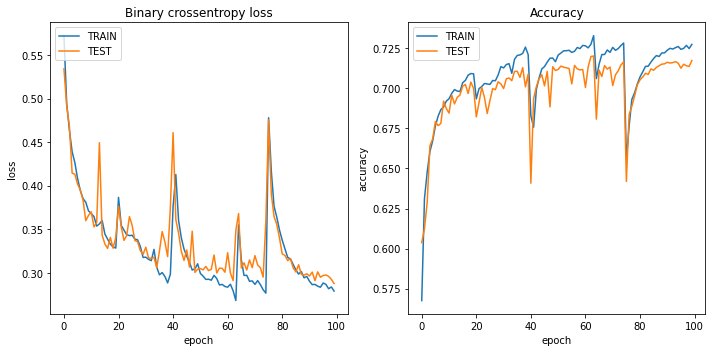

In [12]:
plt.figure(figsize=(10,5))

# Plot loss for each epoch
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Test loss")
plt.title('Binary crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

# Plot accuracy for each epoch
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train accuracy")
plt.plot(history.history['val_accuracy'], label="Test accuracy")
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Make predictions
predictions = model.predict(images_test)

23/23 [==============================] - 1s 27ms/step


In [14]:
def plot_results(threshold=0.5):
    k = np.random.randint(len(images_test))
    original_image = images_test[k]
    mask = mask_test[k].reshape(128,128)
    predicted_mask = predictions[k].reshape(128,128)
    threshold_mask = mask_threshold(predicted_mask, threshold=threshold)

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(original_image);plt.title('Orginal Image')

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray');plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(predicted_mask, cmap='gray');plt.title('Predicted Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(threshold_mask, cmap='gray');plt.title(f'Predicted Mask with cutoff={threshold}')

    plt.tight_layout()
    plt.show()

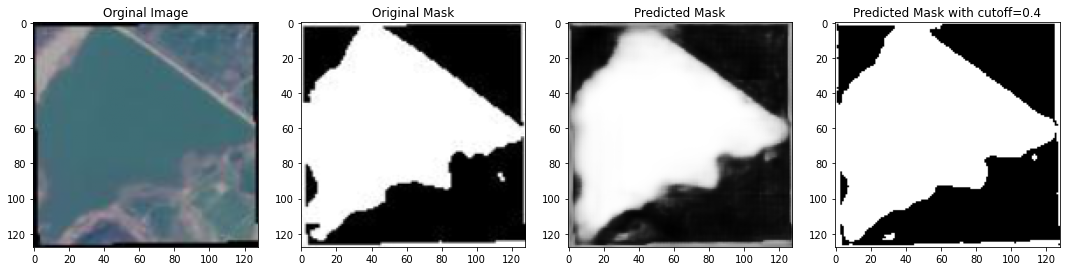

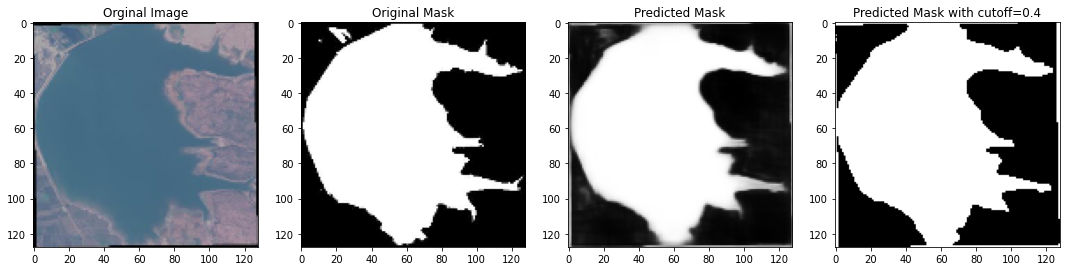

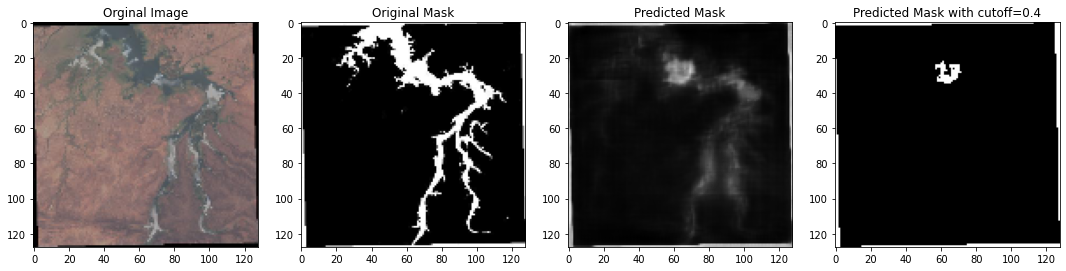

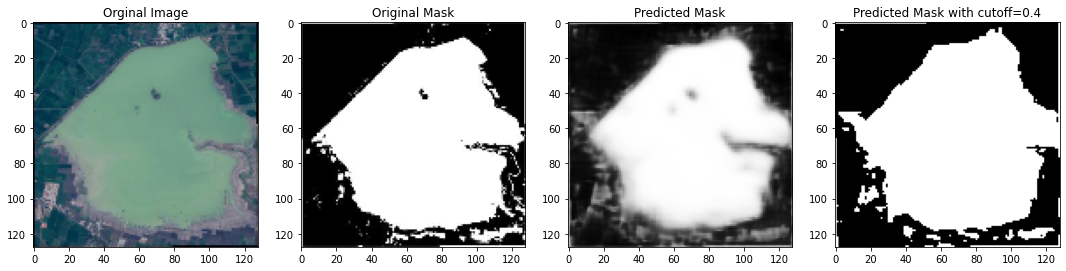

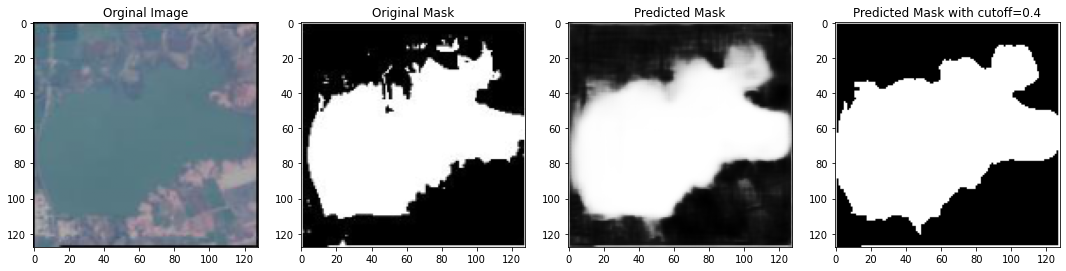

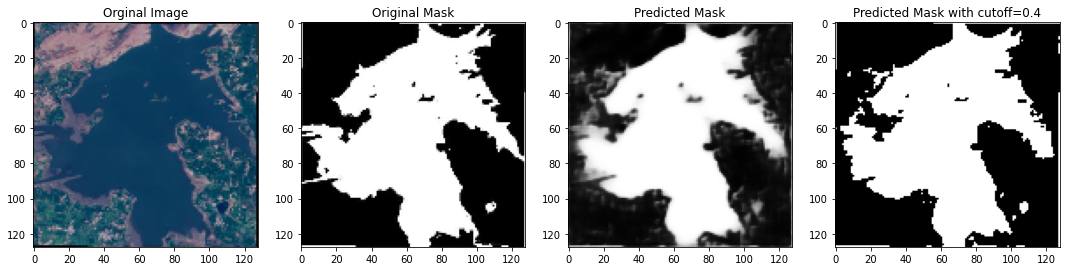

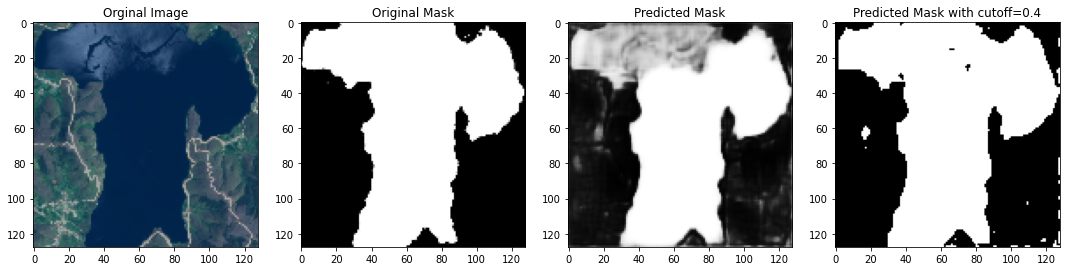

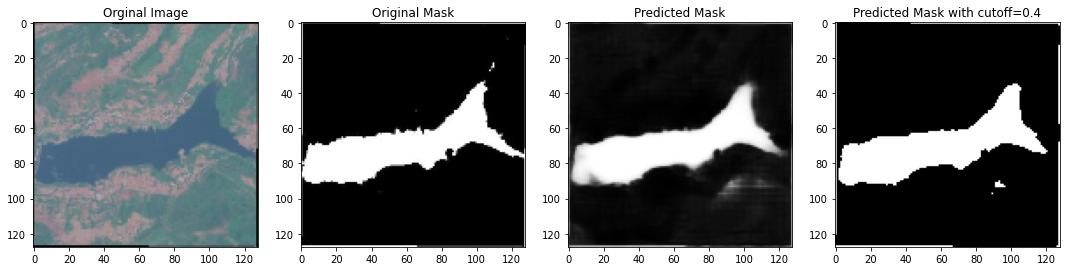

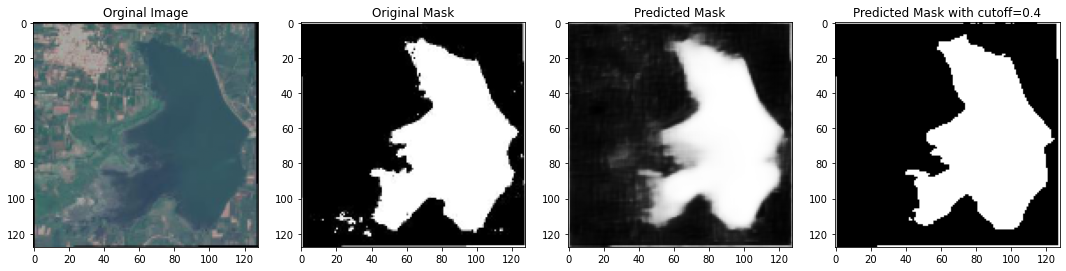

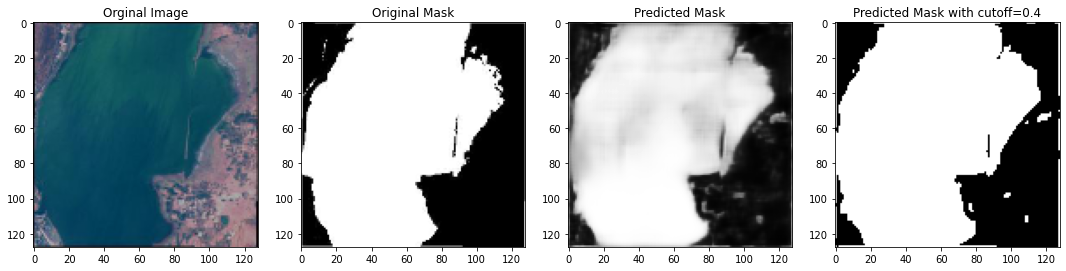

In [22]:
# Plot results on test data
for i in range(10):
  plot_results(threshold=0.4)